# 1.0 - IMPORTS

## 1.1 - LIBRARIES

In [165]:
import pandas                   as pd
import numpy                    as np
import matplotlib.pyplot        as plt
import plotly.express           as px
import seaborn                  as sns
import re
import inflection
import umap.umap_               as umap
from sklearn.cluster            import KMeans, DBSCAN
from sklearn.metrics            import silhouette_score, silhouette_samples
from sklearn.preprocessing      import MinMaxScaler, StandardScaler
from sklearn.decomposition      import PCA
from sklearn.manifold           import TSNE
from yellowbrick.cluster        import KElbowVisualizer, SilhouetteVisualizer
from sklearn.ensemble           import RandomForestRegressor
from sklearn.mixture            import GaussianMixture
from scipy.cluster.hierarchy    import linkage, dendrogram, fcluster
import sqlite3
from sqlalchemy import create_engine



## 1.2 - LOAD DATA

In [78]:
df_raw = pd.read_csv('../dataset/data.csv', encoding='latin-1')

## 1.3 - HELPER FUNCTIONS

### 1.3.1 - NA VOLUMETRY

In [79]:
def nan_volumetry(data):
    df_na = pd.DataFrame()
    df_na['attributes'] = data.columns
    df_na['volumetry'] = ''
    df_na['percentual'] = ''

    for i in df_na.index:
        volumetry = data[df_na.loc[i, 'attributes']].isna().sum()
        percentual = (volumetry / data['customer_id'].count()) * 100
        df_na.loc[i, 'volumetry'] = volumetry
        df_na.loc[i, 'percentual'] = f"{percentual:.2f}%"  

    return df_na

### 1.3.2 - PLOT DIMENSIONS

In [80]:
sns.set(rc = {'figure.figsize':(13,5)})

# 2.0 - DATA DESCRIPTION

In [81]:
df2 = df_raw.copy()

## 2.1 - DATA DIMENSION

In [82]:
print('Total of unique features:\n')
print(df2.apply(lambda x: x.nunique()))
print('\nNumber of rows: {}'.format(df2.shape[0]))
print('Number of cols: {}'.format(df2.shape[1]))

Total of unique features:

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

Number of rows: 541909
Number of cols: 8


## 2.2 - RENAME COLUMNS

In [83]:
old_columns = df2.columns
snakecase = lambda x: inflection.underscore(x)
new_columns = list(map(snakecase, old_columns))
df2.columns = new_columns

## 2.3 - DATA TYPES

In [84]:
df2.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 2.4 - NAN VOLUMETRY

In [85]:
df2.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [86]:
nan_volumetry(df2)

,attributes,volumetry,percentual
0,invoice_no,0,0.00%
1,stock_code,0,0.00%
2,description,1454,0.36%
3,quantity,0,0.00%
4,invoice_date,0,0.00%
5,unit_price,0,0.00%
6,customer_id,135080,33.20%
7,country,0,0.00%


### 2.4.1 - FILL NA

In [87]:
df_missing = df2.loc[df2['customer_id'].isna(),:]
df_full = df2.loc[~df2['customer_id'].isna(),:]

In [88]:
# create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1)

# merge original with reference dataframe
df2 = pd.merge( df2, df_backup, on='invoice_no', how='left' )

# coalesce 
df2['customer_id'] = df2['customer_id_x'].combine_first( df2['customer_id_y'] )

# drop extra columns
df2 = df2.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )
df2.head(6)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,United Kingdom,17850.0
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,United Kingdom,17850.0


In [89]:
df2.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 2.5 - CHANGE DATA TYPES

In [90]:
df2['invoice_date'] = pd.to_datetime(df2['invoice_date'])
df2['customer_id'] = df2['customer_id'].astype(int)

In [91]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

# 3.0 - DESCRIPTIVE STATISTICS

In [92]:
df3 = df2.copy()
num_attributes = df3.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df3.select_dtypes(include = 'object')

## 3.1 - NUMERICAL ATTRIBUTES

In [93]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### 3.1.1 - NUMERICAL ATTRIBUTES ANALYSIS

- Negative Quantity (Returning products?)
- Unity Price less than zero (Product discount?)

## 3.2 - CATEGORICAL ATTRIBUTES

In [94]:
cat_attributes.columns

Index(['invoice_no', 'stock_code', 'description', 'country'], dtype='object')

### INVOICE NUMBER

We have Invoice Number with letters and numbers, sendo assim iremos padronizar para uma variavel numerica pois se trata de uma ordem de compra.

In [95]:
df_letter_invoices = df3.loc[df3['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]
df_letter_invoices.head()

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices: 9291
Total number of negative quantity: 9288


Observando que a coluna Quantity indicam numeros negativos, podemos assumir que são dados relacionados a descontos, devolução ou estorno (cancelamento) de mercadorias pois correspondem a quantidade total de ordens com letras.

STOCK CODE

Analise de stocke code com apenas caracteres

In [96]:
df3.loc[df3['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), :].sample(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
518840,580123,POST,POSTAGE,2,2011-12-01 17:07:00,40.00,Finland,12664
236402,557754,POST,POSTAGE,1,2011-06-22 13:12:00,700.00,Norway,12432
205194,554714,DOT,DOTCOM POSTAGE,1,2011-05-26 10:44:00,155.25,United Kingdom,20761
430116,573580,DOT,DOTCOM POSTAGE,1,2011-10-31 14:21:00,254.42,United Kingdom,22220
344222,566987,POST,POSTAGE,4,2011-09-16 10:56:00,18.00,Germany,12476
265786,560228,M,Manual,10,2011-07-15 17:29:00,0.85,United Kingdom,17750
126346,547071,POST,POSTAGE,2,2011-03-20 13:59:00,18.00,Germany,12693
223023,556469,POST,POSTAGE,3,2011-06-12 11:37:00,18.00,Germany,12516
235989,557669,POST,POSTAGE,2,2011-06-22 09:43:00,18.00,France,12674
120336,546652,DOT,DOTCOM POSTAGE,1,2011-03-15 14:18:00,167.58,United Kingdom,19868


In [97]:
stock_code_letters = df3.loc[df3['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()
stock_code_letters

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

### DESCRIPTION

We'll drop the Description column, because its not usefull or bring some insight ou metric to our analysis.

In [98]:
df3.sample(5)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
167332,550987,21889,WOODEN BOX OF DOMINOES,1,2011-04-21 18:10:00,2.46,United Kingdom,20403
505924,579103,22599,CHRISTMAS MUSICAL ZINC STAR,45,2011-11-28 11:39:00,0.29,United Kingdom,18041
386427,570234,23470,CARD HOLDER LOVE BIRD LARGE,2,2011-10-09 14:22:00,6.25,United Kingdom,17790
216531,555848,84879,ASSORTED COLOUR BIRD ORNAMENT,16,2011-06-07 13:31:00,1.69,United Kingdom,16081
189565,553158,22178,VICTORIAN GLASS HANGING T-LIGHT,12,2011-05-13 15:24:00,1.25,United Kingdom,14194


### COUNTRY

In [99]:
print('Total of unique Countries: {}'.format(df3['country'].unique()))
print('\n Total of number of unique Countries: {}'.format(df3['country'].nunique()))
print('\n Percentual of orders per country:')
(df3['country'].value_counts(normalize = True)*100).apply(lambda x: '{:.2f}%'.format(x))

Total of unique Countries: ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']

 Total of number of unique Countries: 38

 Percentual of orders per country:


country
United Kingdom          91.43%
Germany                  1.75%
France                   1.58%
EIRE                     1.51%
Spain                    0.47%
Netherlands              0.44%
Belgium                  0.38%
Switzerland              0.37%
Portugal                 0.28%
Australia                0.23%
Norway                   0.20%
Italy                    0.15%
Channel Islands          0.14%
Finland                  0.13%
Cyprus                   0.11%
Sweden                   0.09%
Unspecified              0.08%
Austria                  0.07%
Denmark                  0.07%
Japan                    0.07%
Poland                   0.06%
Israel                   0.05%
USA                      0.05%
Hong Kong                0.05%
Singapore                0.04%
Iceland                  0.03%
Canada                   0.03%
Greece                   0.03%
Malta                    0.02%
United Arab Emirates     0.01%
European Community       0.01%
RSA                      0.01%


Quantity of Customers by Country

In [100]:
df3[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending = False)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


# 4.0 - FEATURE SELECTION

In [101]:
df4 = df3.copy()

In [102]:
# === Numerical attributes ====
df4 = df4.loc[df4['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df4 = df4[~df4['stock_code'].isin( stock_code_letters) ]

# description
df4 = df4.drop( columns='description', axis=1 )

# map -  
df4 = df4[~df4['country'].isin( ['European Community', 'Unspecified' ] ) ]

# bad users
df4 = df4[~df4['customer_id'].isin( [16446] )]

# quantity
df_returns = df4.loc[df3['quantity'] < 0, :]
df_purchases = df4.loc[df3['quantity'] >= 0, :]

# 5.0 - FEATURE ENGINEERING

In [103]:
df5 = df4.copy()

In [104]:
df_reference = df5.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis = 1).drop_duplicates(ignore_index = True)

## 5.1 - GROSS REVENUE

In [105]:
#gross Revenue (quantity * price)
df_purchase = df_purchases.copy()
df_purchase.loc[:, 'gross_revenue'] = df_purchase.loc[:, 'quantity'] * df_purchase.loc[:, 'unit_price']


#monetary
df_monetary = df_purchase.loc[:,['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_reference = pd.merge(df_reference, df_monetary, on = 'customer_id', how = 'left')
df_reference.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

## 5.2 - RECENCY - DAY FROM LAST PURCHASE

In [106]:
#recency (Last Day Purchase)
df_recency = df_purchase.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df5['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_reference = pd.merge( df_reference, df_recency, on='customer_id', how='left' )
df_reference.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

## 5.3 - QUANTITY OF PURCHASED

In [107]:
#frequency (Quantity of Purchase)
df_freq = (df_purchase.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                             .groupby( 'customer_id' )
                                                             .count()
                                                             .reset_index()
                                                             .rename( columns={'invoice_no': 'qtde_invoices'}) )
df_reference = pd.merge( df_reference, df_freq, on='customer_id', how='left' )
df_reference.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

## 5.4 - QUANTITY OF ITEMS PURCHASED

In [108]:
#frequency (Quantity of Purchase)
df_freq = (df_purchase.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum()
                                                           .reset_index()
                                                           .rename( columns={'quantity': 'qtde_items'} ) )
df_reference = pd.merge( df_reference, df_freq, on='customer_id', how='left' )
df_reference.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

## 5.5 - QUANTITY OF PRODUCTS PURCHASED

In [109]:
df_freq = (df_purchase.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )
df_reference = pd.merge( df_reference, df_freq, on='customer_id', how='left' )
df_reference.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

## 5.6 - AVERAGE TICKET VALUE

In [110]:
#average ticket
df_avg_ticket = df_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_reference = pd.merge( df_reference, df_avg_ticket, on='customer_id', how='left')
df_reference.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

## 5.7 - AVERAGE RECENCY DAYS

In [111]:
df_aux = df4[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=False )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_reference = pd.merge( df_reference, df_avg_recency_days, on='customer_id', how='left' )
df_reference.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2744
dtype: int64

## 5.8 - FREQUENCY PURCHASE

In [112]:
df_aux = ( df_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_reference = pd.merge( df_reference, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_reference.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2744
frequency             91
dtype: int64

## 5.9 - NUMBER OF RETURNS

In [113]:
df_returns = df_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_reference = pd.merge( df_reference, df_returns, how='left', on='customer_id' )
df_reference.loc[df_reference['qtde_returns'].isna(), 'qtde_returns'] = 0

df_reference.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2744
frequency             91
qtde_returns           0
dtype: int64

## 5.10 - BASKET SIZE

In [114]:
df_aux = ( df_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_reference = pd.merge( df_reference, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_reference.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2744
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

## 5.11 - UNIQUE ITENS BASKET SIZE

In [115]:
df_aux = ( df_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_reference = pd.merge( df_reference, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_reference.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2744
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

## 5.12 - CLEANING NA

In [116]:
df_reference = df_reference.dropna()
df_reference.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

# 6.0 - EXPLORATORY DATA ANALYSIS (EDA)

In [117]:
df6 = df_reference.copy()

## 6.2 - SPACE STUDY ANALYSIS

In [118]:
df_space = df6.drop(columns = ['customer_id'], axis = 1).copy()
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df_space = df6[cols_selected].copy()
df_space.columns

Index(['customer_id', 'gross_revenue', 'recency_days', 'qtde_products',
       'frequency', 'qtde_returns'],
      dtype='object')

In [119]:
mms = MinMaxScaler()

df_space['gross_revenue']               = mms.fit_transform(df_space[['gross_revenue']])
df_space['recency_days']                = mms.fit_transform(df_space[['recency_days']])
df_space['qtde_products']               = mms.fit_transform(df_space[['qtde_products']])
df_space['frequency']                   = mms.fit_transform(df_space[['frequency']])
df_space['qtde_returns']                = mms.fit_transform(df_space[['qtde_returns']])

### 6.2.1 - PCA ANALYSIS

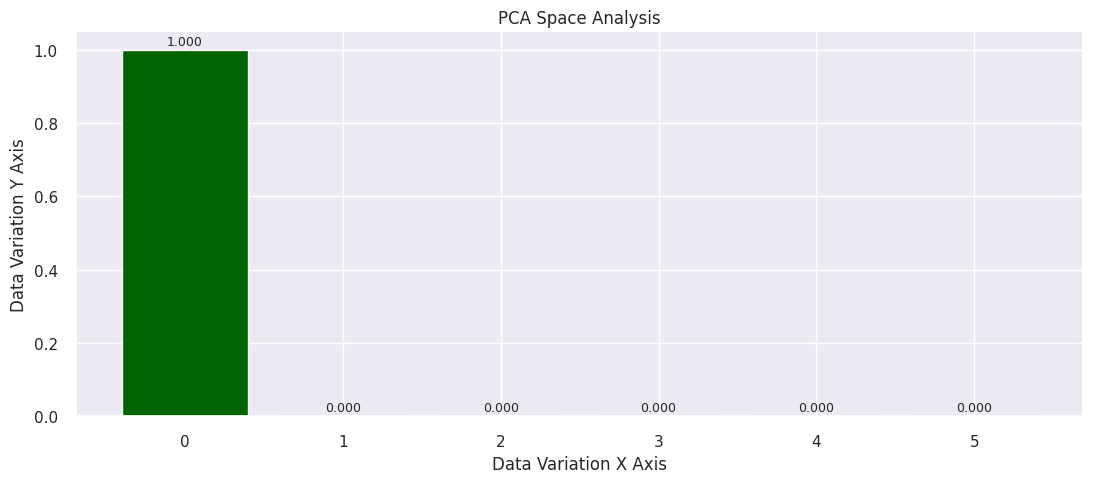

In [120]:
pca = PCA(n_components = df_space.shape[1])

principal_components = pca.fit_transform(df_space)

#plot explained variable
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='darkgreen')
plt.title('PCA Space Analysis')
plt.xlabel('Data Variation X Axis')
plt.ylabel('Data Variation Y Axis')

for i, explained_var in enumerate(pca.explained_variance_ratio_):
    plt.text(i, explained_var + 0.005, f'{explained_var:.3f}', ha='center', va='bottom', fontsize=9)

plt.show()

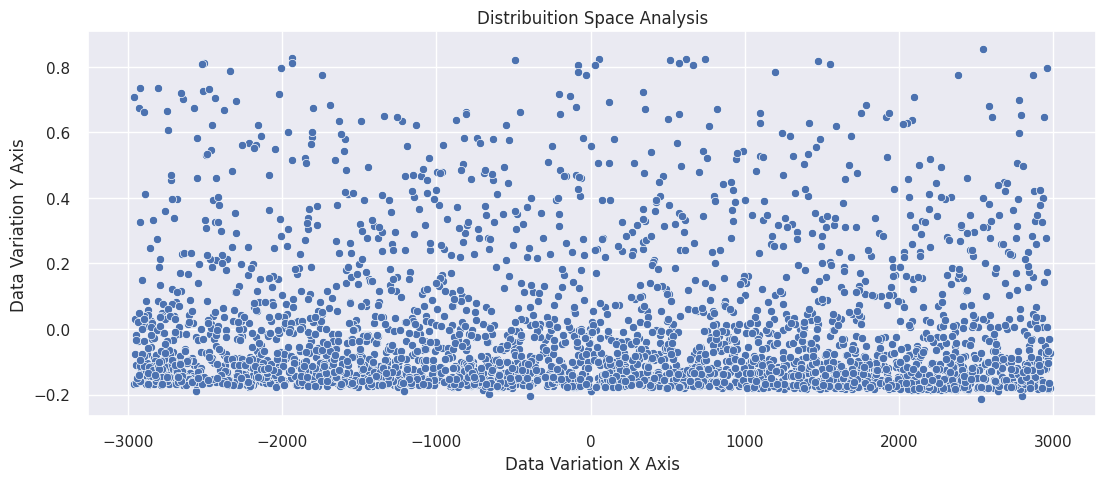

In [121]:
df_pca = pd.DataFrame(principal_components)
df_view = df_pca.loc[df_pca[0] <=3000].copy()
sns.scatterplot(data = df_view, x = 0, y = 1,)
plt.title('Distribuition Space Analysis')
plt.xlabel('Data Variation X Axis')
plt.ylabel('Data Variation Y Axis')
plt.show()

### 6.2.2 - UMAP ANALYSIS

/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


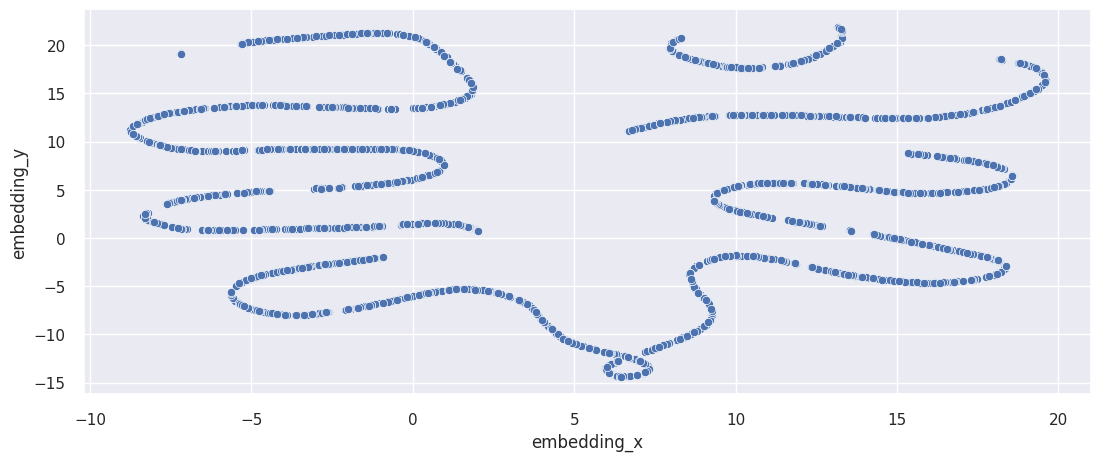

In [122]:
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(df_space)

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot

sns.scatterplot(data = df_pca, x = 'embedding_x', y = 'embedding_y')

plt.show()

### 6.2.3 - T-SNE ANALYSIS

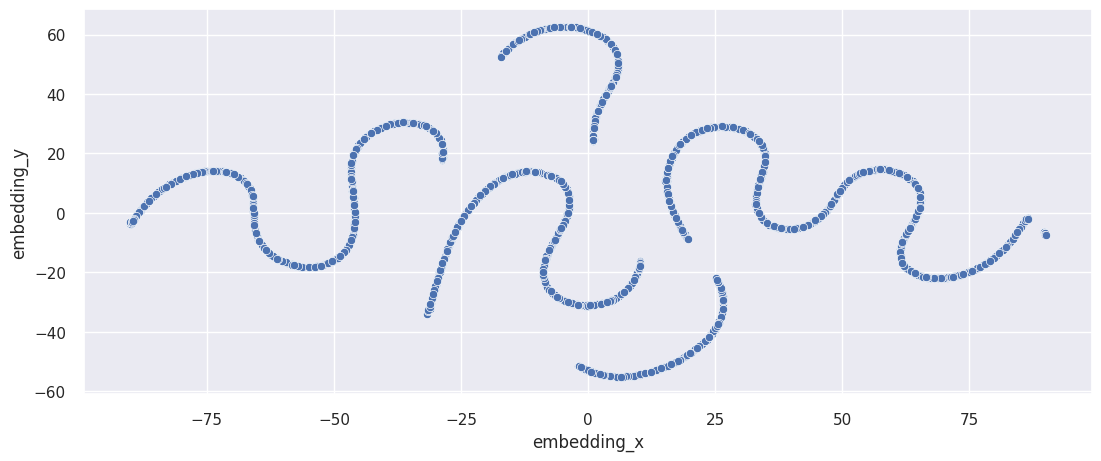

In [123]:
reducer = TSNE(random_state = 42, n_components = 2, n_jobs = -1, )
embedding = reducer.fit_transform(df_space)

#embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot

sns.scatterplot(data = df_pca, x = 'embedding_x', y = 'embedding_y')

plt.show()

### 6.2.4 - TREE-BASED EMBEDDING ANALYSIS

In [124]:
#dataset split
x_train = df_space.drop(columns = ['customer_id', 'gross_revenue'], axis = 1)
y_train = df_space['gross_revenue']

#model definition
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 42)

#model training
rf_model.fit(x_train, y_train)

#leaf
leaf = rf_model.apply(x_train)

#dataframe leaf
df_leaf = pd.DataFrame(leaf)
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,3746,3656,3622,3746,3397,3739,3559,3486,3677,3724,...,3541,3483,3532,3645,3536,3639,3720,3823,3563,3625
1,3622,3532,3478,3236,3347,3359,2960,3111,3556,3135,...,3424,3081,3446,3401,3439,3479,3117,3145,3410,3228
2,3701,3574,3563,3280,3373,3107,3532,3511,3470,3676,...,3422,3492,3592,3455,3533,3551,3654,3702,3604,3635
3,1210,436,406,425,1332,843,1037,624,429,1044,...,1059,466,1099,895,1230,1248,887,369,820,770
4,495,587,69,658,719,1058,91,477,686,738,...,442,931,465,732,585,498,550,759,123,1062


/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


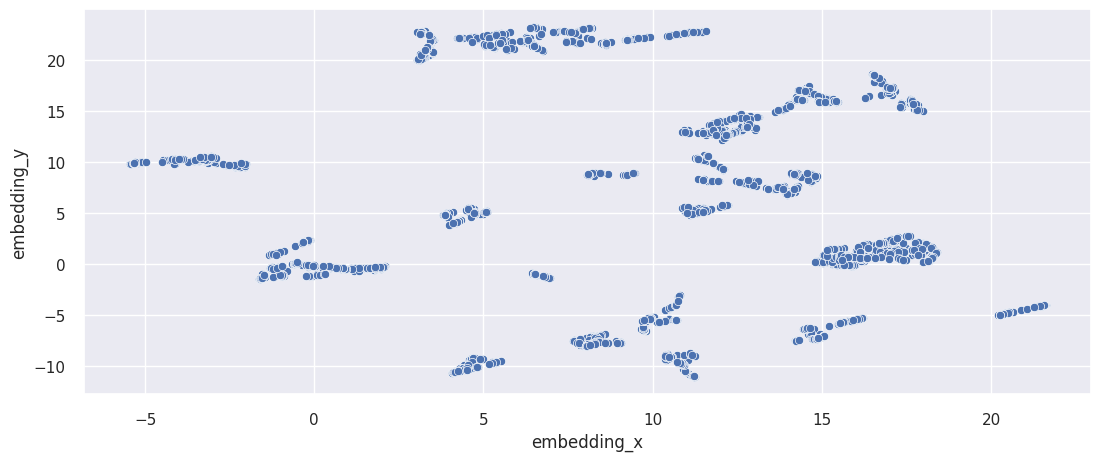

In [125]:
#Reduce of dimensionality
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(df_leaf)

#embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

#plot

sns.scatterplot(data = df_tree, x = 'embedding_x', y = 'embedding_y')

plt.show()

# 7.0 - DATA PREPARATION

In [126]:
df7 = df_tree.copy()


## 7.1 - RESCALING

In [127]:
#mms = MinMaxScaler()

#df7['gross_revenue']            = mms.fit_transform(df7[['gross_revenue']])
#df7['recency_days']             = mms.fit_transform(df7[['recency_days']])
#df7['quantity_stock_code']      = mms.fit_transform(df7[['quantity_stock_code']])
#df7['frequency']                = mms.fit_transform(df7[['frequency']])
#df7['returns']                  = mms.fit_transform(df7[['returns']])


# 8.0 - HYPERPARAMETER FINE-TUNNING

In [128]:
df8 = df7.copy()

In [129]:
#cols_selected = df8[['customer_id','gross_revenue', 'recency_days', 'quantity_stock_code', 'frequency', 'returns']]
#parameter_tuning = cols_selected.copy()
#parameter_tuning = parameter_tuning.drop(columns = ['customer_id'], axis = 1)
parameter_tuning = df8.copy()

In [130]:
parameter_tuning

,embedding_x,embedding_y
0,5.543434,22.580914
1,16.679857,18.211548
2,6.618283,23.148361
3,-2.891562,9.862707
4,10.475513,-5.449882
...,...,...
3034,3.280359,20.977346
3035,14.057353,15.516663
3036,10.747486,-3.611966
3037,14.184395,7.354157


In [131]:
cluster = np.arange(2, 26, 1)

## 8.1 - K-MEANS

In [132]:
kmeans_list = []
for k in cluster:
    #model definition
    kmeans = KMeans(n_clusters = k)

    #model traning
    kmeans.fit(parameter_tuning)

    #validation
    labels = kmeans.predict(parameter_tuning)

    #performance
    sil = silhouette_score(parameter_tuning, labels, metric = 'euclidean')
    kmeans_list.append(sil)

/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/erickvieira/.pyenv/versions/

/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/erickvieira/.pyenv/versions/3.11.7/envs/clusteringvenv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/erickvieira/.pyenv/versions/

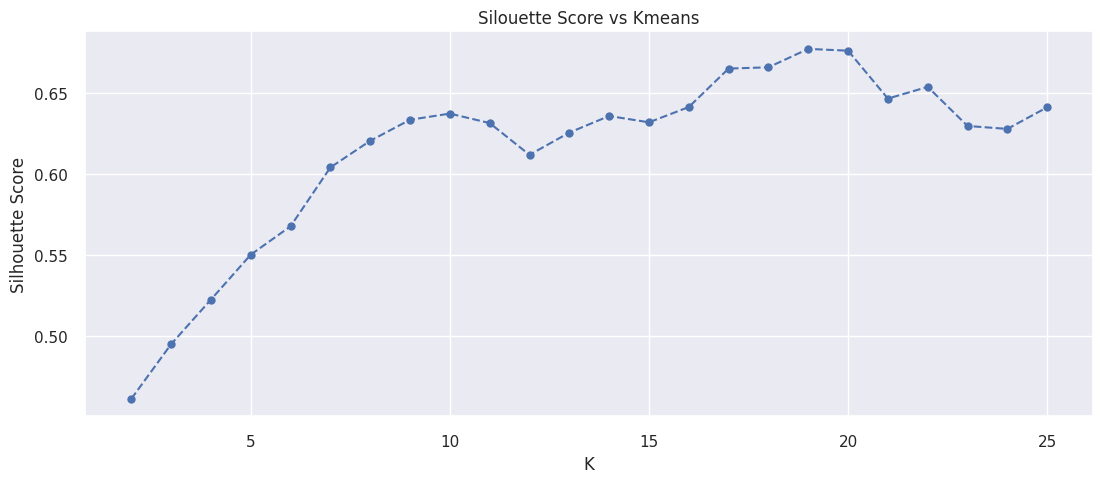

In [133]:
plt.plot(cluster, kmeans_list, linestyle = '--', marker = 'o', color = 'b')
plt.title('Silouette Score vs Kmeans')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show() 


## 8.2 - GAUSSIAN MIXTURE MODEL (GMM)

In [134]:
gmm_list = []
for k in cluster:
    #model definition
    gmm = GaussianMixture(n_components= k)

    #model traning
    gmm.fit(parameter_tuning)

    #validation
    labels = gmm.predict(parameter_tuning)

    #performance
    sil = silhouette_score(parameter_tuning, labels, metric = 'euclidean')
    gmm_list.append(sil)

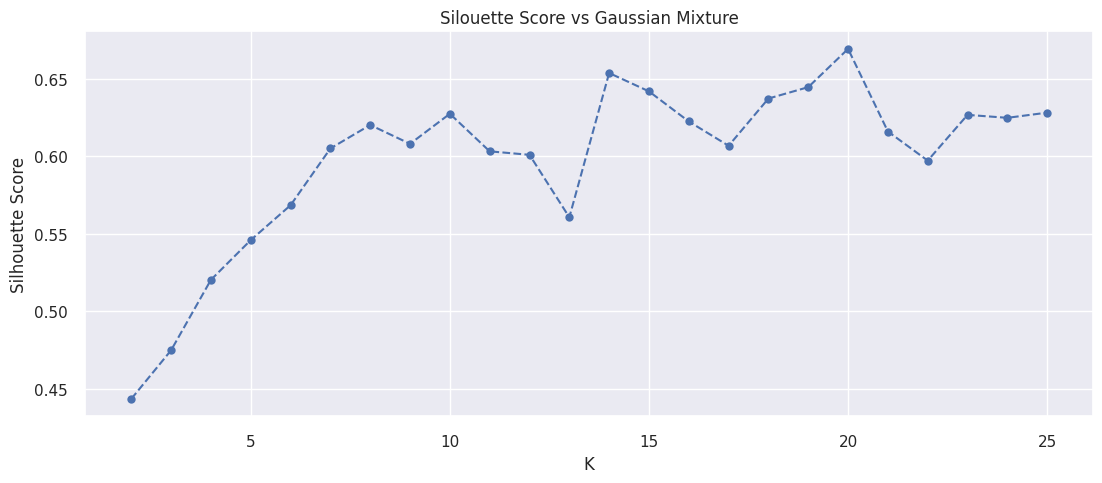

In [135]:
plt.plot(cluster, gmm_list, linestyle = '--', marker = 'o', color = 'b')
plt.title('Silouette Score vs Gaussian Mixture')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show() 

## 8.3 - HIERARCHICAL CLUSTERING

In [136]:
#Definition and training model
hc_model = linkage(parameter_tuning, 'ward')

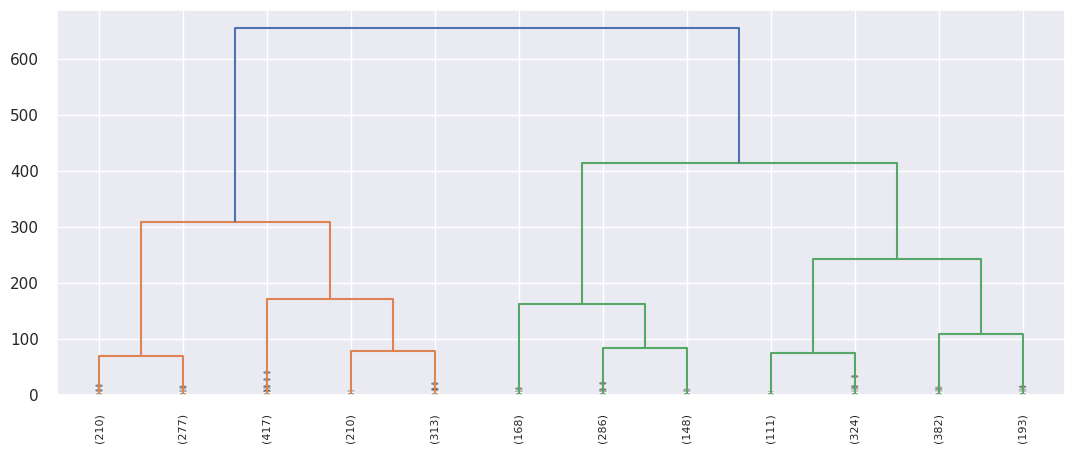

In [137]:
#plot
dendrogram(hc_model, leaf_rotation = 90, leaf_font_size = 8, truncate_mode='lastp', p = 12, show_contracted=True)
plt.show()


### 8.3.1 - HIERARCHICAL CLUSTERING SILHOUETTE SCORE

In [138]:
hc_list = []
for k in cluster:
    #model definition
    hc_model = linkage(parameter_tuning, 'ward')

    #model predict
    labels = fcluster(hc_model, k, criterion = 'maxclust')

    #performance
    sil = silhouette_score(parameter_tuning, labels, metric = 'euclidean')

    hc_list.append(sil)

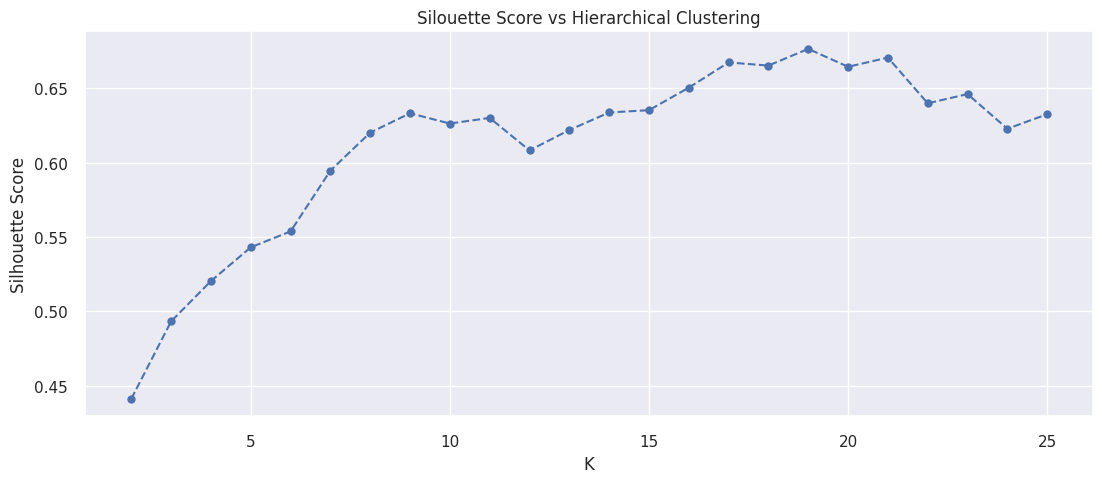

In [139]:
plt.plot(cluster, hc_list, linestyle = '--', marker = 'o', color = 'b')
plt.title('Silouette Score vs Hierarchical Clustering')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show() 

## 8.5 - RESULTS OF PERFORMANCE

In [140]:
df_results = pd.DataFrame({'Kmeans': kmeans_list, 'Gaussian Mixture Model': gmm_list, 'Hierarchical Clustering': hc_list}).T
df_results.columns = cluster
df_results.style.highlight_max(color='darkgreen', axis = 1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
Kmeans,0.461004,0.494748,0.522265,0.549972,0.567498,0.603803,0.620234,0.633213,0.637010,0.631171,0.611561,0.625308,0.635540,0.631636,0.641053,0.664803,0.665579,0.676941,0.675825,0.646289,0.653510,0.629392,0.627569,0.640907
Gaussian Mixture Model,0.443512,0.474872,0.520318,0.545966,0.568458,0.605081,0.620234,0.608068,0.627455,0.603228,0.600979,0.560682,0.653752,0.641921,0.622498,0.606821,0.637296,0.644641,0.669324,0.616020,0.597240,0.626754,0.624847,0.628196
Hierarchical Clustering,0.441029,0.493170,0.520318,0.543032,0.553729,0.594614,0.620234,0.633213,0.626326,0.630123,0.608224,0.621967,0.633752,0.635318,0.650451,0.667427,0.665326,0.676553,0.664500,0.670712,0.639937,0.646159,0.622799,0.632595


# 9.0 - MACHINE LEARNING MODEL

## 9.1 - K-MEANS

In [141]:
#model definition
k = 8
kmeans = KMeans(init = 'random', n_clusters = k, n_init = 10, max_iter = 300, random_state = 42)

#model training
kmeans.fit(parameter_tuning)

#clustering
labels = kmeans.labels_

### 9.1.1 - CLUSTER PERFOMANCE

In [142]:
print('WSS Value: {}'.format(kmeans.inertia_))
print('Silhouette Score Value: {}'.format(silhouette_score(parameter_tuning, labels, metric = 'euclidean')))

WSS Value: 23167.6640625
Silhouette Score Value: 0.6202337145805359


### 9.1.2 - CLUSTER ANALYSIS

In [143]:
df10 = parameter_tuning.copy()
df10['cluster'] = labels
df10.head(10)

,embedding_x,embedding_y,cluster
0,5.543434,22.580914,4
1,16.679857,18.211548,2
2,6.618283,23.148361,4
3,-2.891562,9.862707,0
4,10.475513,-5.449882,5
5,11.311625,10.355288,1
6,5.332528,22.505344,4
7,15.407749,0.856821,7
8,3.241874,22.754866,4
9,4.330956,4.272226,3


### 9.1.3 - VISUALIZATION INSPECTION

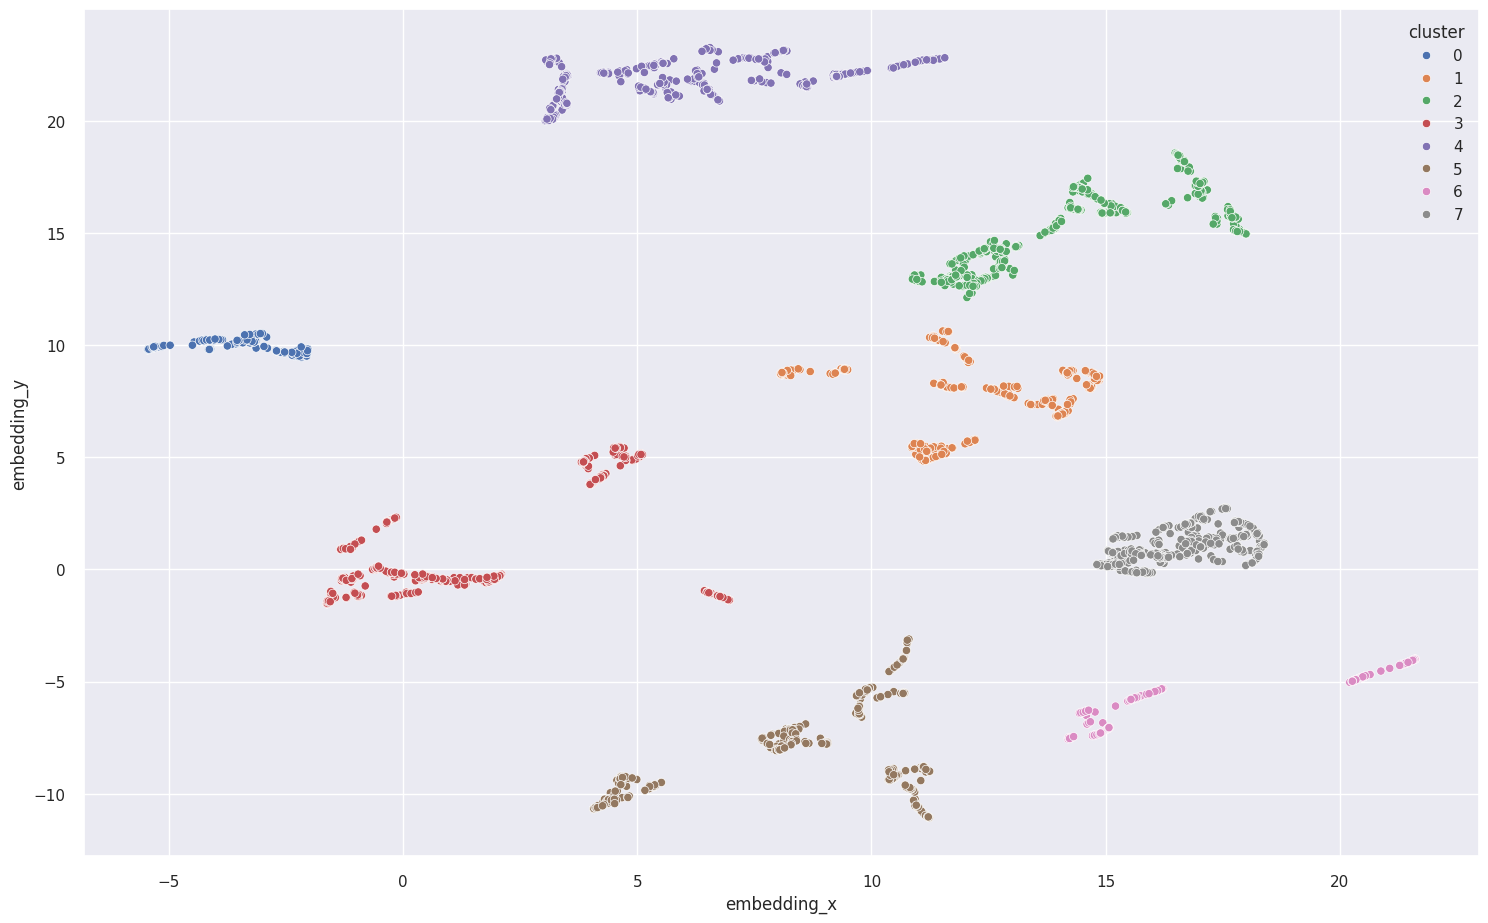

In [144]:
plt.figure(figsize=(18, 11))
sns.scatterplot(data = df10, x = 'embedding_x', y = 'embedding_y', hue = 'cluster', palette='deep')
plt.show()

## 9.2 - GAUSSIAN MIXTURE MODEL

In [145]:
k = 8
#model definition
gmm = GaussianMixture(n_components= k, random_state=42)

#model traning
gmm.fit(parameter_tuning)

#validation
labels = gmm.predict(parameter_tuning)

#performance
sil = silhouette_score(parameter_tuning, labels, metric = 'euclidean')
gmm_list.append(sil)

### 9.2.1 - CLUSTER PERFOMANCE

In [146]:
print('Silhouette Score Value: {}'.format(silhouette_score(parameter_tuning, labels, metric = 'euclidean')))

Silhouette Score Value: 0.5960385799407959


### 9.2.2 - CLUSTER ANALYSIS

In [147]:
df10 = parameter_tuning.copy()
df10['cluster'] = labels
df10.head(10)

,embedding_x,embedding_y,cluster
0,5.543434,22.580914,1
1,16.679857,18.211548,5
2,6.618283,23.148361,1
3,-2.891562,9.862707,6
4,10.475513,-5.449882,4
5,11.311625,10.355288,3
6,5.332528,22.505344,1
7,15.407749,0.856821,0
8,3.241874,22.754866,1
9,4.330956,4.272226,2


### 9.2.3 - VISUALIZATION INSPECTION

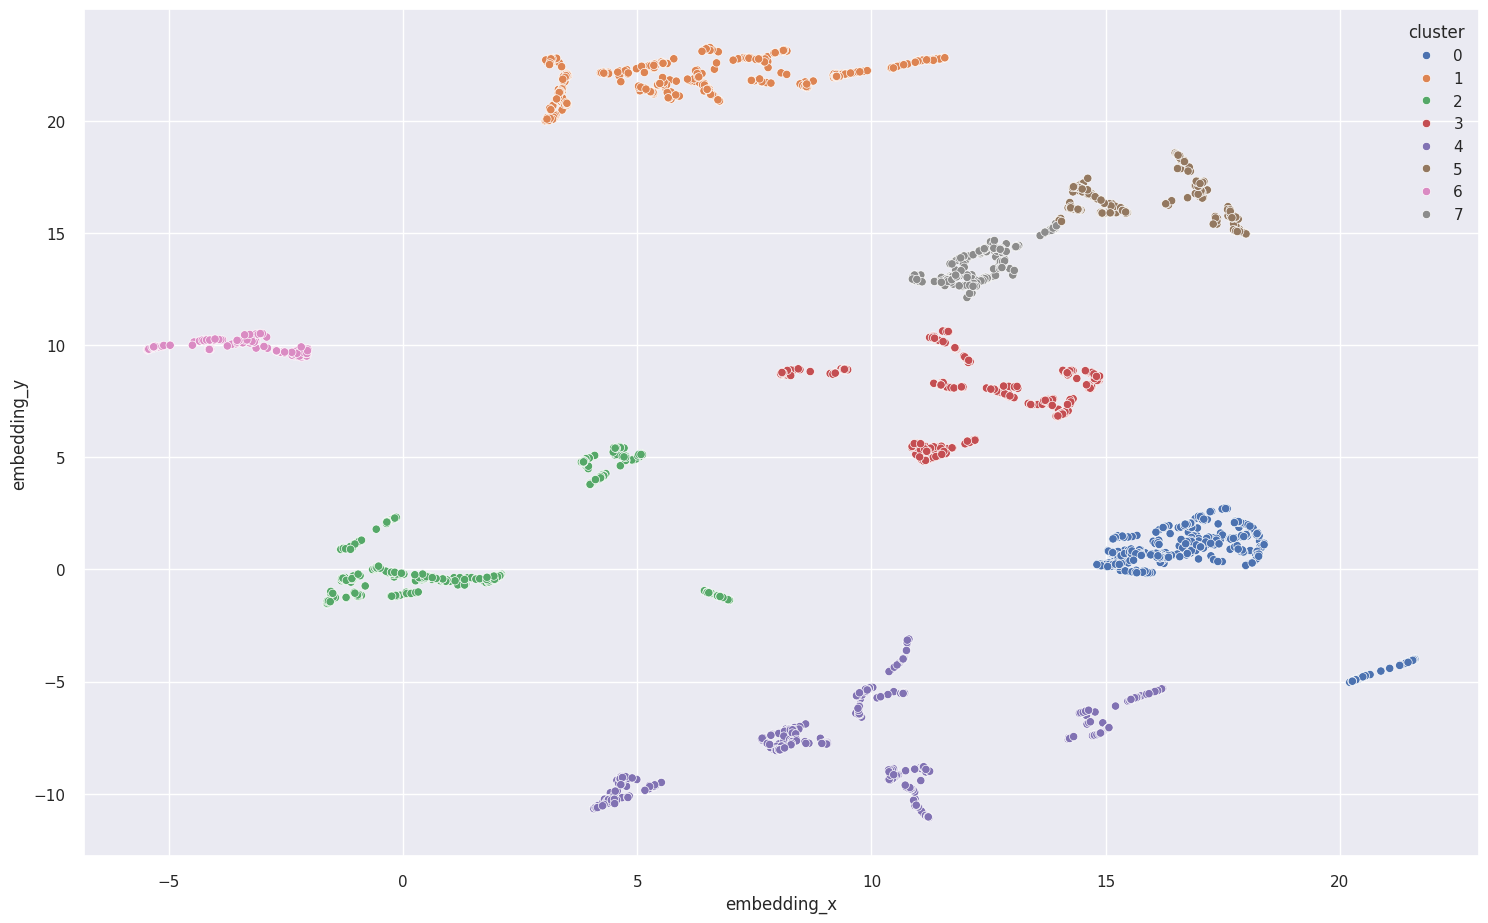

In [148]:
plt.figure(figsize=(18, 11))
sns.scatterplot(data = df10, x = 'embedding_x', y = 'embedding_y', hue = 'cluster', palette='deep')
plt.show()

# 10.0 - VISUALIZATION INSPECTION

## 10.1 - 10.1 - 2D PLOT

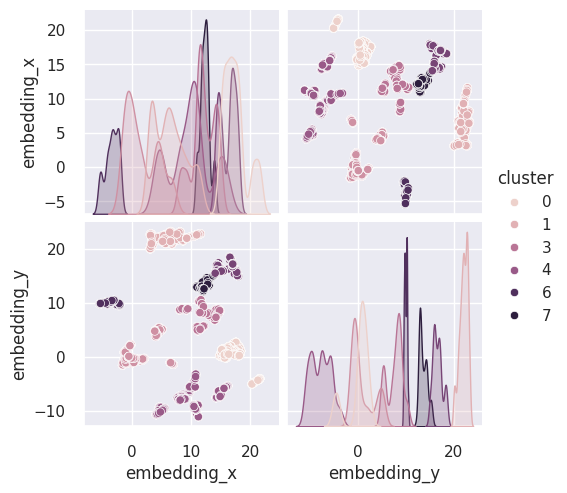

In [149]:
df_viz = df10.copy()
sns.pairplot(df_viz, hue = 'cluster')
plt.show()

## 10.2 - UMAP - HIGH DIMENSIONALITY

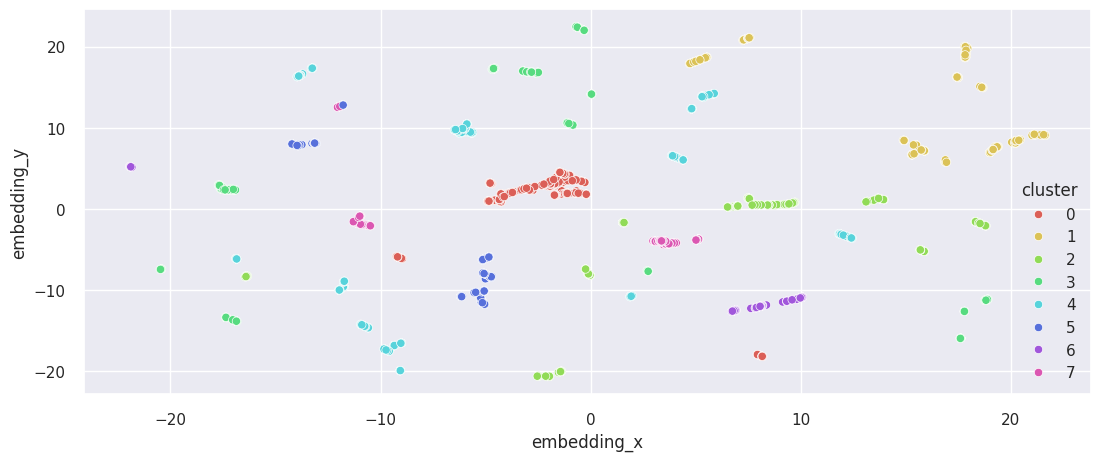

In [150]:
reducer = umap.UMAP(random_state = 42, n_neighbors = 200, n_jobs = 1)
embedding = reducer.fit_transform(parameter_tuning)

#embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

#plot

sns.scatterplot(data = df_viz, x = 'embedding_x', y = 'embedding_y', 
                hue = 'cluster', 
                palette = sns.color_palette( 'hls', n_colors = len(df_viz['cluster'].unique())))

plt.show()

## 10.4 - CLUSTER PROFILE

In [158]:
df_profile = df6[cols_selected].copy()
df_profile['cluster'] = labels

In [159]:
df_profile['recency_days'] = df_profile['recency_days'].astype(int)
df_profile['qtde_products'] = df_profile['qtde_products'].astype(int)
df_profile['qtde_returns'] = df_profile['qtde_returns'].astype(int)

# Number of customer
df_cluster = df_profile[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['percentual_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df_profile[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df_profile[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_qtde_products = df_profile[['qtde_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster' )

# Frequency
df_frequency = df_profile[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )

# Returns
df_qtde_returns = df_profile[['qtde_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_returns, how='inner', on='cluster' )

df_cluster['recency_days'] = df_cluster['recency_days'].astype(int)
df_cluster['qtde_products'] = df_cluster['qtde_products'].astype(int)
df_cluster['qtde_returns'] = df_cluster['qtde_returns'].astype(int)

df_cluster = df_cluster.sort_values('gross_revenue', ascending=False)

new_order_comuns = ['customer_id', 'cluster', 'percentual_customer', 'frequency','recency_days', 'qtde_products', 'qtde_returns', 'gross_revenue']
df_cluster = df_cluster[new_order_comuns]
df_cluster

,customer_id,cluster,percentual_customer,frequency,recency_days,qtde_products,qtde_returns,gross_revenue
1,487,1,16.025008,0.099853,20,419,298,9544.570739
5,289,5,9.509707,0.170576,49,154,26,3028.327301
7,234,7,7.699901,0.021513,38,124,20,2164.522222
3,417,3,13.721619,0.108976,56,88,10,1803.204005
2,434,2,14.281013,0.103137,71,45,6,1069.551959
0,461,0,15.169464,0.274366,95,46,6,1039.054881
6,168,6,5.528134,0.179553,88,27,4,798.631429
4,549,4,18.065153,0.244711,97,14,16,600.265027


 DIAMOND - CLUSTER 01 (Candidate High Value Customer):
 - Total of customers: 487 (16.03% of all customers)
 - Average of Gross Revenue: $9,544.57
 - Average of Recency Days: 20
 - Average of invoice number: 419
 - Average of Returns: 298
 - Average Purchase Frequency: 0.09%

 <br>

SILVER PRODUCTS - CLUSTER 05:
 - Total of customers: 523 (17.21% of all customers)
 - Average of Gross Revenue: $2,641.84
 - Average of Recency Days: 44
 - Average of invoice number: 140
 - Average of Returns: 24
 - Average Purchase Frequency: 0.10%

 <br>
 
BRONZE MONEY CLUSTER 07:
 - Total of customers: 417 (13.72% of all customers)
 - Average of Gross Revenue: $1,803.20
 - Average of Recency Days: 56
 - Average of invoice number: 88
 - Average of Returns: 10
 - Average Purchase Frequency: 0.10%

 <br>
 
BRONZE PRODUCTS CLUSTER 03:
 - Total of customers: 382 (12.57% of all customers)
 - Average of Gross Revenue: $1,198.02
 - Average of Recency Days: 61
 - Average of invoice number: 54
 - Average of Returns: 7
 - Average Purchase Frequency: 0.09%

 <br>
 
SILVER LESS DAYS - CLUSTER 02:
 - Total of customers: 343 (14.28% of all customers)
 - Average of Gross Revenue: $1,069.55
 - Average of Recency Days: 71
 - Average of invoice number: 45
 - Average of Returns: 6
 - Average Purchase Frequency: 0.09%

 <br>
 
SILVER LOWER PURCHASE - CLUSTER 0:
 - Total of customers: 168 (5.53% of all customers)
 - Average of Gross Revenue: $798.63
 - Average of Recency Days: 88
 - Average of invoice number: 27
 - Average of Returns: 4
 - Average Purchase Frequency: 0.17%

 <br>
 
SILVER STOP RETURNS - CLUSTER 06:
 - Total of customers: 435 (14.31% of all customers)
 - Average of Gross Revenue: $656.33
 - Average of Recency Days: 94	
 - Average of invoice number: 14
 - Average of Returns: 19
 - Average Purchase Frequency: 0.06%

 <br>
 
BRONZE LOWER PURCHASE - CLUSTER 04:
 - Total of customers: 193 (6.35% of all customers)
 - Average of Gross Revenue: $338.86
 - Average of Recency Days: 169	
 - Average of invoice number: 13
 - Average of Returns: 5
 - Average Purchase Frequency: 1.0%



# 11.0 - DEPLOY

## 11.1 - CREATE DB CONNECTION

In [167]:
query_create_table_diamond = """
    CREATE TABLE diamond(
        customer_id INTEGER,
        gross_revenue REAL,
        recency_days INTEGER,
        qtde_products INTEGER,
        frequency REAL,
        qtde_returns INTEGER,
        cluster INTEGER
    )
"""

connection = sqlite3.connect('diamond_db.sqlite')
connection.execute(query_create_table_diamond)
connection.commit()
connection.close()


## 11.2 - INSERT DATA

In [168]:
connection = create_engine('sqlite:///diamond_db.sqlite')
df_profile.to_sql('diamond', con = connection, if_exists='append', index = False)

3039

## 11.3 - VIEW DATA

In [169]:
query = """ SELECT * FROM diamond"""
df_query = pd.read_sql_query(query, connection)

In [170]:
df_query

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,371,297,17.000000,40,1
1,13047,3232.59,56,171,0.028302,35,5
2,12583,6705.38,2,232,0.040431,50,1
3,13748,948.25,95,28,0.017921,0,6
4,15100,876.00,333,3,0.073171,22,4
...,...,...,...,...,...,...,...
3034,13521,1092.39,0,435,0.333333,0,1
3035,15060,301.84,7,120,4.000000,0,5
3036,12558,269.96,7,11,1.000000,196,4
3037,16000,12393.70,2,9,3.000000,0,3
